In [2]:
import matplotlib.pyplot as plt
import numpy as np
from pylbm import lbm
from scipy.optimize import curve_fit

In [3]:
epochs = 3000
eps = 0.1
omegas = np.arange(0.1, 1.91, 0.2).round(decimals=1)
x_dim, y_dim = 30, 30

font_size = 20
plt.rc('axes', titlesize=font_size)
plt.rc('axes', labelsize=font_size)

### Choose an initial distribution of  $ρ(r,t)$  and  $u(r,t)$  at  $t=0$  such as  $ρ(r,0)=ρ_0+ε \sin(2πx / L_x)$  and  $u(r,0)=0$ . Where  $L_x$  is the length of the domain in the  $x$  direction. Observe what happens with the 2D density distribution in time.

/tmp/ipykernel_8734/1797772294.py:25: RuntimeWarning: overflow encountered in exp
  return a * np.cos(b * x) * np.exp(-c * x) + d


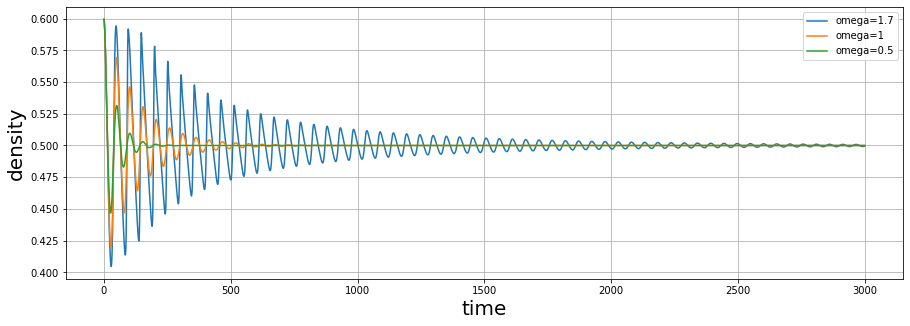

In [44]:
x = np.arange(x_dim)
y = np.arange(y_dim)
X, Y = np.meshgrid(x, y)
r_mean, u_mean = 0.5, 0.0

fig, ax = plt.subplots(figsize=(15,5))

for o in [1.7,1,0.5]:
    vs_emp = []
    r_xy = lbm.density_init(x_dim=x_dim, y_dim=y_dim, r_mean=r_mean, eps=0.0)
    r_xy += eps * np.sin(2.0 * np.pi / x_dim * X).T

    u_axy = lbm.local_avg_velocity_init(x_dim=x_dim, y_dim=y_dim, u_mean=u_mean, eps=0.0)
    f_cxy = lbm.f_eq(u_axy=u_axy, r_xy=r_xy)

    densities = []
    for e in range(epochs):
        # use max density (j dim doesn't matter)
        densities.append(r_xy[x_dim // 4, 0])
        f_cxy = lbm.stream(f_cxy=f_cxy)
        f_cxy, u_axy = lbm.collision(f_cxy=f_cxy, omega=o)
        r_xy = lbm.density(f_cxy=f_cxy)

    def func(x, a, b, c, d):
        return a * np.cos(b * x) * np.exp(-c * x) + d

    popt, pcov = curve_fit(func, np.arange(epochs), densities)
    v = popt[2] / (2 * np.pi / x_dim) ** 2
    vs_emp.append(v)
    densities = np.array(densities)
    ax.plot(np.arange(epochs),densities, label='omega='+str(o))


ax.set_xlabel("time")
ax.set_ylabel("density")
# ax.set_title("Density decay, omega=0.5")
ax.legend()
ax.grid(True)
lbm.save_fig(fig, 'm3-1-density-decay.pgf')
plt.show()
plt.close()

### M3.2 Choose an initial distribution of  $ρ(r,0)=1$  and  $u_x(r,0)=ε\sin(2πy / L_y)$ , i.e. a sinusoidal variation of the velocities  $u_x$  with the position  $y$ . Observe in both cases what happens dynamically as well as in the long time limit  $t→∞$ .

In [4]:
x = np.arange(x_dim)
y = np.arange(y_dim)
X, Y = np.meshgrid(x, y)
r_mean, u_mean = 1, 0.0

amps_total = []
velocities_print = []
for omega in omegas:
    velocities_omega = []
    r_xy = lbm.density_init(x_dim=x_dim, y_dim=y_dim, r_mean=r_mean, eps=0.0)

    u_axy = lbm.local_avg_velocity_init(x_dim=x_dim, y_dim=y_dim, u_mean=u_mean, eps=0.0)
    u_axy[0] += eps * np.sin(2.0 * np.pi / y_dim * Y).T
    f_cxy = lbm.f_eq(u_axy=u_axy, r_xy=r_xy)

    amps_emp = []
    for e in range(epochs):
        # amps_emp.append(r_xy[x_dim // 4, 0])
        if e % (epochs//10) == 0:
            # choose any i value, all y values
            velocities_omega.append([u_axy[0, 0, :], e])

        amp = u_axy[0, 0, :]
        # amps_emp.append(amp.max() - amp.mean())
        amps_emp.append(u_axy[0, 0, :].max())

        f_cxy = lbm.stream(f_cxy=f_cxy)
        f_cxy, u_axy = lbm.collision(f_cxy=f_cxy, omega=omega)
        r_xy = lbm.density(f_cxy=f_cxy)
    velocities_print.append(velocities_omega)
    

    amps_emp = np.array(amps_emp)
    amps_total.append([omega, amps_emp])



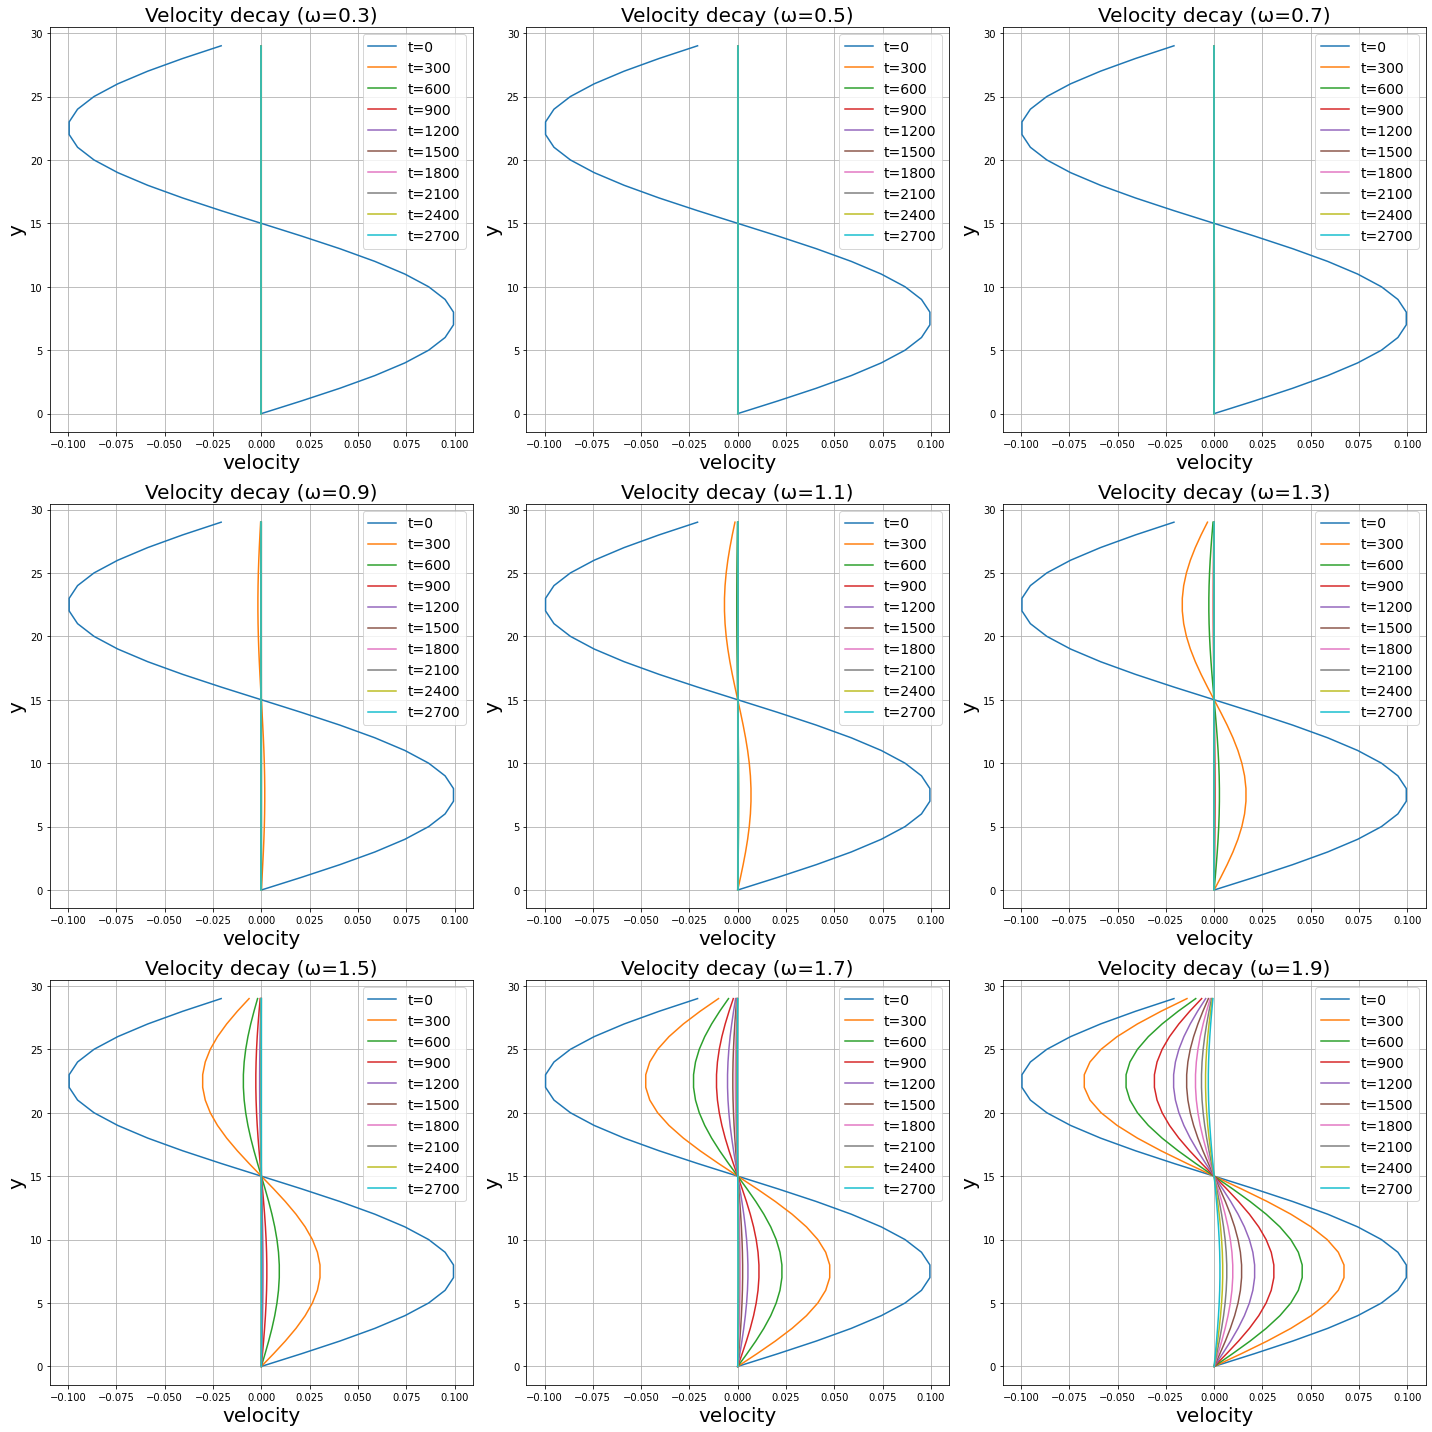

In [14]:
fig, ax = plt.subplots(figsize=(20,20))
plt.axis('off')
axs = fig.subplots(nrows=3, ncols=3)
for i, velocities, omega in zip(np.arange(10)[1:]-1, velocities_print[:], omegas[1:]):
    if i < 3:
        ax = axs[0,i%3]
    elif i<6:
        ax = axs[1,i%3]
    elif i<9:
        ax = axs[2,i%3]
    ax.set_title("Velocity decay (ω={})".format(str(omega)))
    ax.set_xlabel("velocity")
    ax.set_ylabel("y")
    for v in velocities: 
        ax.plot(v[0],np.arange(y_dim), label="t={}".format(v[1]))
    # if i==0:
    ax.legend(fontsize=14)
    ax.grid()
plt.tight_layout()
lbm.save_fig(fig, 'm3-2-velocity-decay.pgf')
plt.show()
plt.close()

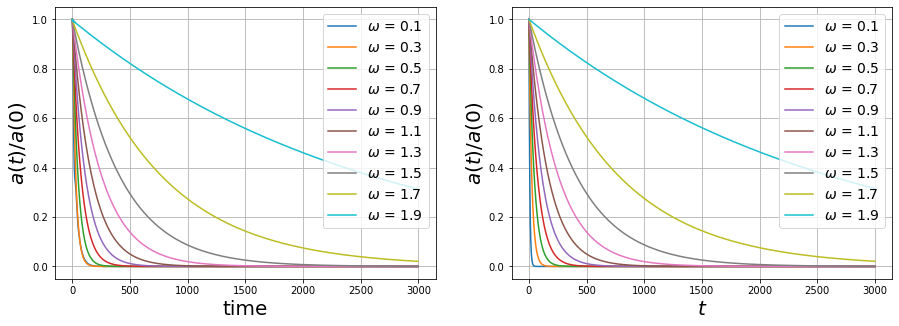

In [17]:
fig, ax = plt.subplots(figsize=(15,5))
plt.axis('off')
axs = fig.subplots(nrows=1, ncols=2)

ax = axs[0]
for a in amps_total:
    ax.plot(np.arange(epochs), a[1]/a[1][0], label='$\omega$ = {}'.format(a[0].round(1)))
# ax.set_title("Shear Wave Decay (empirical normalized amplitude)")
ax.set_xlabel('time')
ax.set_ylabel('$a(t)/a(0)$')
ax.legend(fontsize=14)
ax.grid()

ax = axs[1]
plots = []
for omega in omegas:
    amplitudes = []
    for e in range(epochs):
        nu = 1/3*(1/omega - 1/2)
        amp = np.exp(-nu*(2*np.pi/y_dim)**2*e)
        amplitudes.append(amp)
    plots.append([omega, amplitudes])
for p in plots:
    ax.plot(np.arange(epochs), p[1], label="$\omega$ = {}".format(p[0].round(1)))
# ax.set_title("Shear Wave Decay (theoretical normalized amplitude)")
ax.set_xlabel('$t$')
ax.set_ylabel('$a(t)/a(0)$')
ax.legend(fontsize=14)
ax.grid()

fig.savefig("./m3_2-shear-wave-decay.pgf")
plt.show()
plt.close()

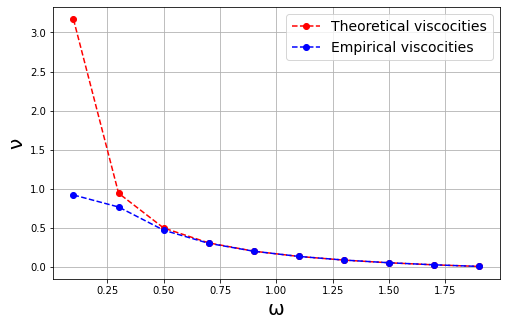

In [16]:
fig, ax = plt.subplots(figsize=(8,5))
nys_emp = []
for amp in amps_total:
    def func(x, a):
        return np.exp(-a*x*((2*np.pi/y_dim)**2))
    popt, pcov = curve_fit(func, np.arange(epochs), amp[1]/amp[1][0])
    nys_emp.append(popt[0])
vs_theo = 1/3*(1/omegas-0.5)
ax.plot(omegas,vs_theo,'--ro', label='Theoretical viscocities')
ax.plot(omegas,nys_emp,'--bo', label='Empirical viscocities')
# ax.set_title("Kinematic viscosity scaling with  ω")
ax.set_xlabel('ω')
ax.set_ylabel('ν')
ax.legend(fontsize=14)
ax.grid()
lbm.save_fig(fig, 'm3-3-kinematic-viscocity-scaling.pgf')
plt.show()
plt.close()